In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.genmod.families as families
from statsmodels.genmod.families import Gamma
from statsmodels.genmod.families.links import Log 
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import pmdarima as pm
from pmdarima import auto_arima

In [205]:
# Variable Descriptors
#  AWU - Average Weeks Unemployed
#  CLF - Civilian Labor Force 
#  EPR - Employment Population Ratio
#  LFPR - Civilian Labor Force Participation Rate
#  TNE - Total Nonfarm Employment
#  U3 - U-3 Unemployment Rates
#  UA - U.S. city average, All Items
#  UFH - U.S. city average, Food at home
#  UG - U.S. city average, Gasoline
#  USH - U.S. city average, Housing
#  USM - U.S. city average, Medical Care
#  UST - U.S. city average, Transportation

In [206]:
# Read and preprocess Data 
all_df = pd.read_csv('data.csv')

scaler = StandardScaler()
all_df[['AWU', 'CLF', 'EPR', 'LFPR', 'TNE', 'UA', 'UFH', 'UG', 'USH', 'USM', 'UST']] = scaler.fit_transform(all_df[['AWU', 'CLF', 'EPR', 'LFPR', 'TNE', 'UA', 'UFH', 'UG', 'USH', 'USM', 'UST']])

all_df['U3_lag1'] = all_df['U3'].shift(1)

post_covid = all_df.copy()
post_covid.drop(all_df.head(563).index, inplace=True) 

In [207]:
columns_of_interest = [
    "AWU", "CLF", "EPR", "LFPR", "TNE", "U3", 
    "UA", "UFH", "UG", "USH", "USM", "UST"
]

df_subset = post_covid[columns_of_interest]

descriptive_stats = df_subset.describe()

print(descriptive_stats)

             AWU        CLF        EPR       LFPR        TNE         U3  \
count  34.000000  34.000000  34.000000  34.000000  34.000000  34.000000   
mean    0.312823   1.387598  -0.252577  -1.215112   1.556704   3.735294   
std     0.268434   0.084897   0.093041   0.125322   0.122460   0.226812   
min    -0.009548   1.208515  -0.488965  -1.475672   1.309796   3.400000   
25%     0.169009   1.306069  -0.308354  -1.309565   1.471374   3.600000   
50%     0.237684   1.413052  -0.263201  -1.198827   1.574713   3.700000   
75%     0.402505   1.462986  -0.172896  -1.101932   1.658643   3.875000   
max     1.199142   1.504863  -0.127743  -1.032720   1.726175   4.300000   

              UA        UFH         UG        USH        USM        UST  
count  34.000000  34.000000  34.000000  34.000000  34.000000  34.000000  
mean    1.924590   1.968924   1.882849   2.021877   1.762964   2.045235  
std     0.147074   0.169298   0.403376   0.206592   0.056215   0.147279  
min     1.584125   1.506400 

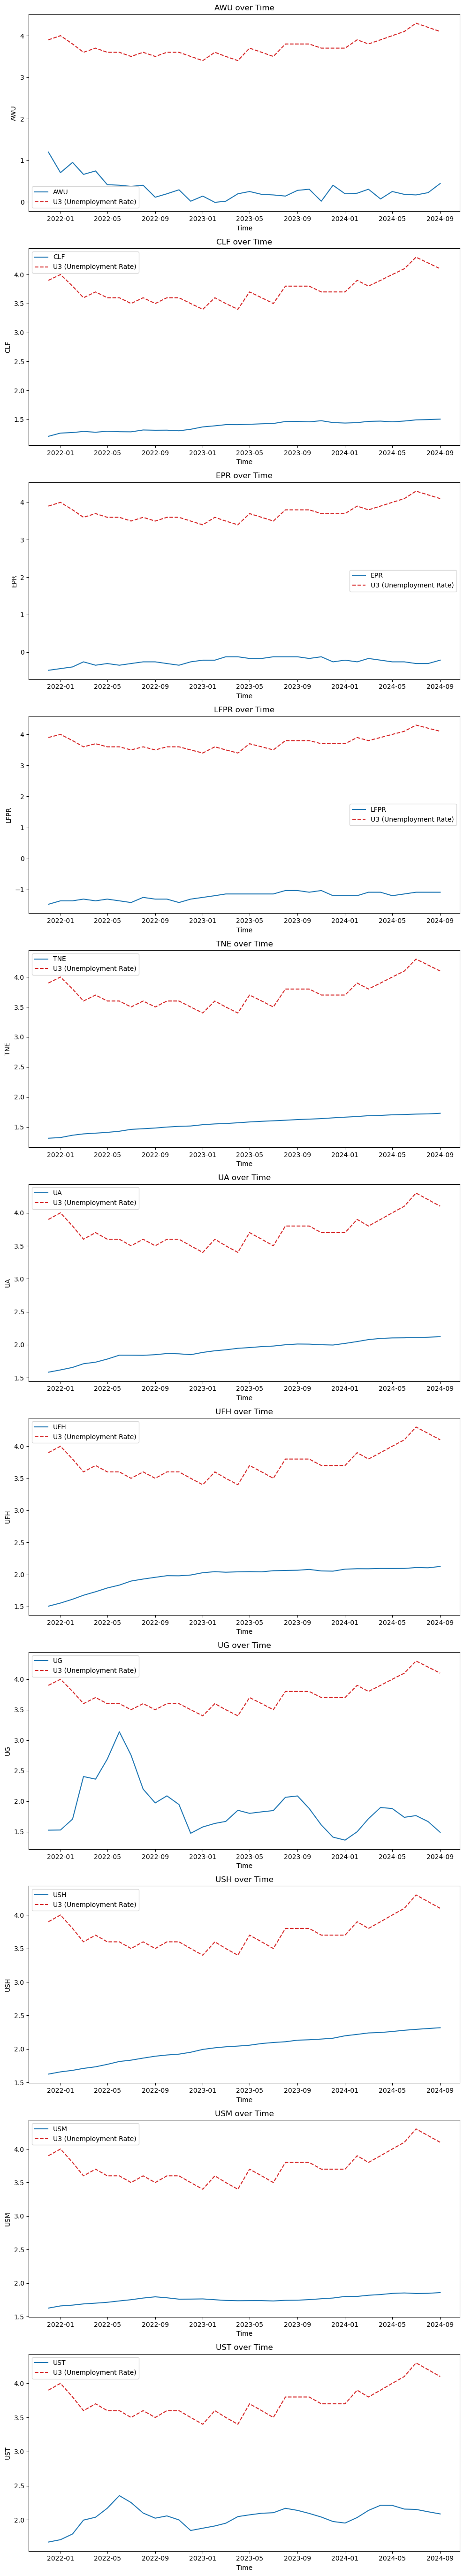

In [208]:
# Vizualise all data
post_covid['Date'] = pd.to_datetime(post_covid['Date'])

post_covid.set_index('Date', inplace=True)

features = ['AWU', 'CLF', 'EPR', 'LFPR', 'TNE', 'UA', 'UFH', 'UG', 'USH', 'USM', 'UST']
target_variable = 'U3'

# Create a plot for each feature
fig, axes = plt.subplots(len(features), 1, figsize=(10, len(features) * 5))

for i, feature in enumerate(features):
    ax = axes[i]
    ax.plot(post_covid.index, post_covid[feature], label=feature, color='tab:blue')
    ax.plot(post_covid.index, post_covid[target_variable], label='U3 (Unemployment Rate)', color='tab:red', linestyle='--')
    ax.set_title(f'{feature} over Time')
    ax.set_xlabel('Time')
    ax.set_ylabel(f'{feature}')
    ax.legend()

plt.tight_layout()
plt.show()

In [209]:
# Log-transform the 'UG' (Gasoline) feature
post_covid['log_UG'] = np.log(post_covid['UG'] + 1)  

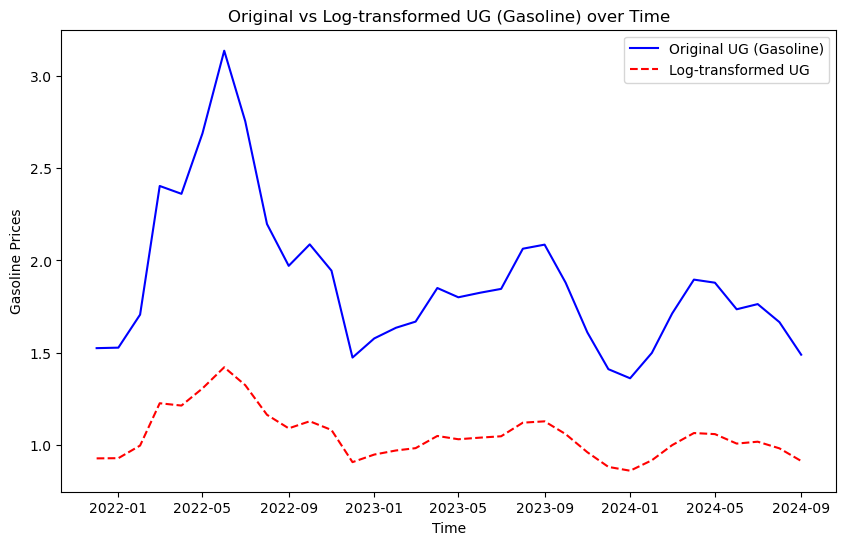

In [211]:
# Plot original and log-transformed 'UG' to compare
plt.figure(figsize=(10, 6))
plt.plot(post_covid.index, post_covid['UG'], label='Original UG (Gasoline)', color='blue')
plt.plot(post_covid.index, post_covid['log_UG'], label='Log-transformed UG', color='red', linestyle='--')
plt.title('Original vs Log-transformed UG (Gasoline) over Time')
plt.xlabel('Time')
plt.ylabel('Gasoline Prices')
plt.legend()
plt.show()

    Feature           VIF
0     const  48710.778991
1       AWU      8.481231
2       CLF    193.451093
3       EPR     10.435184
4      LFPR     39.995687
5       TNE    680.182946
6        UA   4719.111320
7       UFH    103.142113
8    log_UG     49.535124
9       USH   4031.570703
10      USM     19.490590
11      UST    125.770625
12  U3_lag1      6.407183


<Axes: >

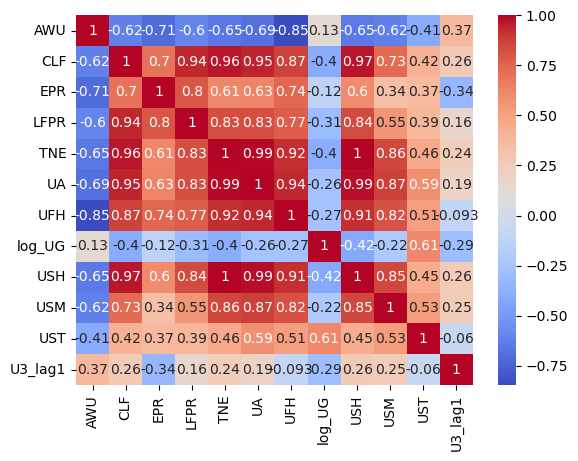

In [213]:
# Initial VIF on post_covid
X_covid = post_covid[['AWU', 'CLF', 'EPR', 'LFPR', 'TNE', 'UA', 'UFH', 'log_UG', 'USH', 'USM', 'UST', 'U3_lag1']].values  
y_covid = post_covid['U3'].values 

X_covid = sm.add_constant(X_covid) 

vif_data = pd.DataFrame()
vif_data["Feature"] = ['const'] + ['AWU', 'CLF', 'EPR', 'LFPR', 'TNE', 'UA', 'UFH', 'log_UG', 'USH', 'USM', 'UST', 'U3_lag1']
vif_data["VIF"] = [variance_inflation_factor(X_covid, i) for i in range(X_covid.shape[1])]

print(vif_data)

corr_matrix = post_covid[['AWU', 'CLF', 'EPR', 'LFPR', 'TNE', 'UA', 'UFH', 'log_UG', 'USH', 'USM', 'UST', 'U3_lag1']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

   Feature          VIF
0    const  1489.861336
1      EPR     1.491930
2   log_UG     1.163048
3      USM     1.364354
4  U3_lag1     1.505048


<Axes: >

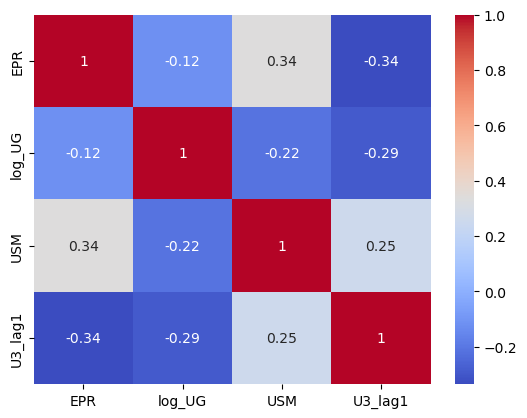

In [214]:
# Final VIF on post_covid
X_covid = post_covid[['EPR', 'log_UG', 'USM', 'U3_lag1']].values  
y_covid = post_covid['U3'].values 

X_covid = sm.add_constant(X_covid) 

vif_data = pd.DataFrame()
vif_data["Feature"] = ['const'] + ['EPR', 'log_UG', 'USM', 'U3_lag1']
vif_data["VIF"] = [variance_inflation_factor(X_covid, i) for i in range(X_covid.shape[1])]

print(vif_data)

corr_matrix = post_covid[['EPR', 'log_UG', 'USM', 'U3_lag1']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

In [215]:
# Train the model
gamma_model_covid = sm.GLM(y_covid, X_covid, family=Gamma(link=Log())).fit()
y_pred_gamma_covid = gamma_model_covid.predict(X_covid)

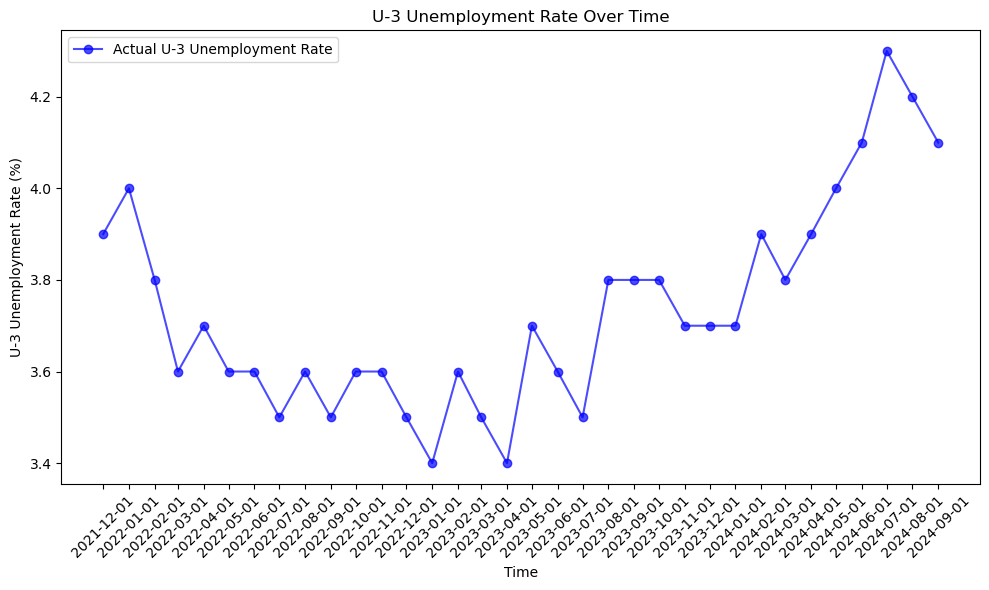

In [216]:
# Scatter plot of unemployment rate (U-3) vs. time
plt.figure(figsize=(10, 6))
plt.plot(post_covid.index, post_covid['U3'], color='blue', marker='o', linestyle='-', alpha=0.7, label='Actual U-3 Unemployment Rate')
plt.xlabel('Time')
plt.ylabel('U-3 Unemployment Rate (%)')
plt.title('U-3 Unemployment Rate Over Time')
plt.xticks(post_covid.index, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

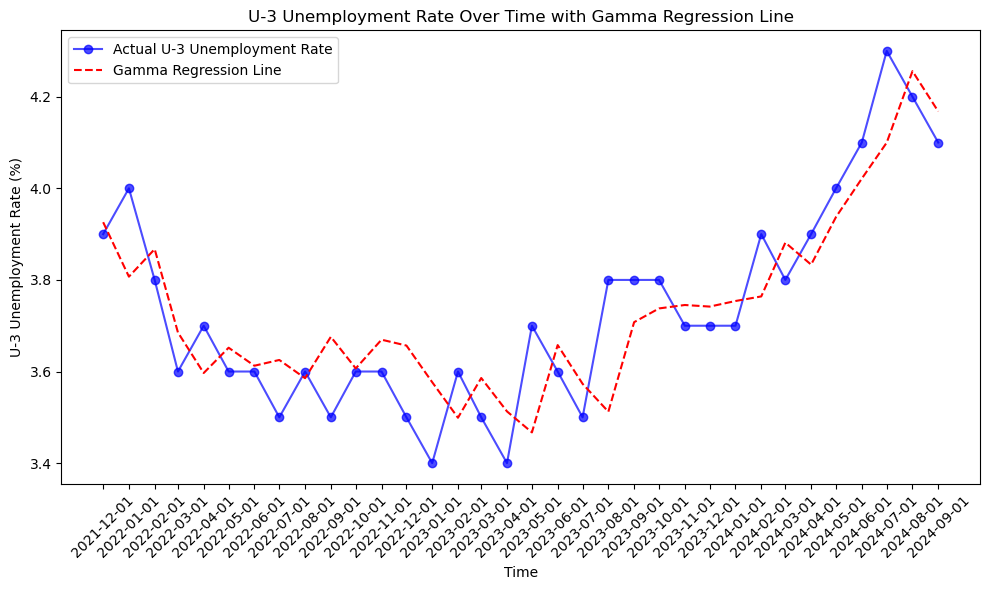

In [217]:
# Plot the Gamma Regression line ontop of the Unemployment Rate
X_covid_full = sm.add_constant(post_covid[['EPR', 'log_UG', 'USM', 'U3_lag1']].values) 
y_pred_gamma_full = gamma_model_covid.predict(X_covid_full)

plt.figure(figsize=(10, 6))
plt.plot(post_covid.index, post_covid['U3'], color='blue', marker='o', linestyle='-', alpha=0.7, label='Actual U-3 Unemployment Rate')
plt.plot(post_covid.index, y_pred_gamma_full, color='red', linestyle='--', label='Gamma Regression Line')
plt.xlabel('Time')
plt.ylabel('U-3 Unemployment Rate (%)')
plt.title('U-3 Unemployment Rate Over Time with Gamma Regression Line')
plt.xticks(post_covid.index, rotation=45)
plt.legend()
plt.tight_layout()  
plt.show()

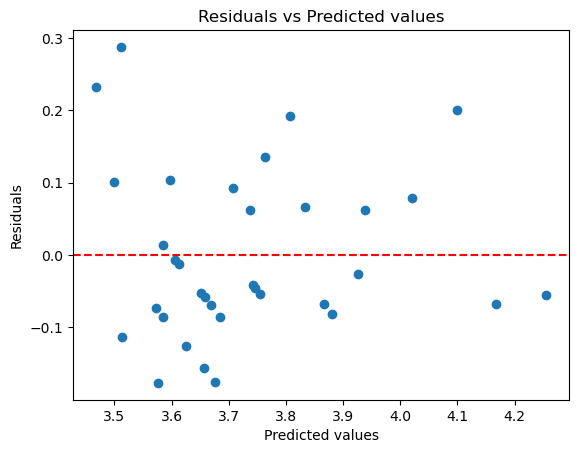

In [218]:
# Plotting the residuals
residuals = y_covid - y_pred_gamma_covid
plt.scatter(y_pred_gamma_covid, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted values')
plt.show()

In [219]:
# Checking model summary, mainly looking at Pseduo R-Squ
print(gamma_model_covid.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   34
Model:                            GLM   Df Residuals:                       29
Model Family:                   Gamma   Df Model:                            4
Link Function:                    Log   Scale:                       0.0011665
Method:                          IRLS   Log-Likelihood:                 24.520
Date:                Wed, 11 Dec 2024   Deviance:                     0.033361
Time:                        00:50:29   Pearson chi2:                   0.0338
No. Iterations:                     6   Pseudo R-squ. (CS):             0.8840
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1520      0.226      0.672      0.5

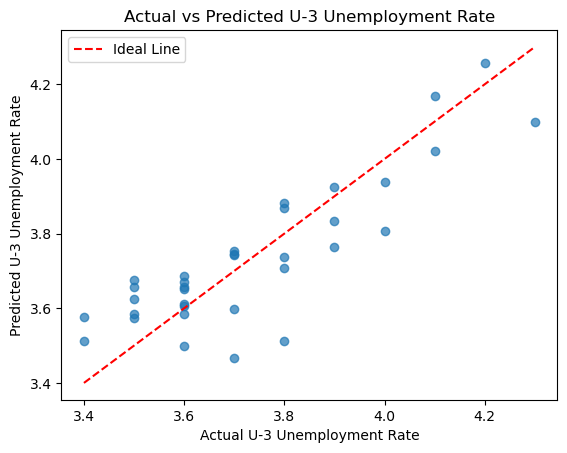

In [220]:
# Checking actual vs predicted another way
plt.scatter(y_covid, y_pred_gamma_covid, alpha=0.7)
plt.plot([min(y_covid), max(y_covid)], [min(y_covid), max(y_covid)], color='red', linestyle='--', label="Ideal Line")
plt.xlabel('Actual U-3 Unemployment Rate')
plt.ylabel('Predicted U-3 Unemployment Rate')
plt.title('Actual vs Predicted U-3 Unemployment Rate')
plt.legend()
plt.show()

In [221]:
# 5-fold CV to check average MSE, RMSE, and AIC
kf = KFold(n_splits=5, shuffle=True, random_state=42) 

mse_list = []
rmse_list = []
aic_list = []

for train_index, val_index in kf.split(X_covid):
    X_train_cv, X_val_cv = X_covid[train_index], X_covid[val_index]
    y_train_cv, y_val_cv = y_covid[train_index], y_covid[val_index]
    
    gamma_model_cv = sm.GLM(y_train_cv, X_train_cv, family=Gamma(link=Log())).fit()
    
    y_pred_cv = gamma_model_cv.predict(X_val_cv)
    
    mse_cv = mean_squared_error(y_val_cv, y_pred_cv)
    rmse_cv = np.sqrt(mse_cv)
    aic_cv = gamma_model_cv.aic
    
    mse_list.append(mse_cv)
    rmse_list.append(rmse_cv)
    aic_list.append(aic_cv)

avg_mse = np.mean(mse_list)
avg_rmse = np.mean(rmse_list)
avg_aic = np.mean(aic_list)

print(f"Average MSE: {avg_mse}")
print(f"Average RMSE: {avg_rmse}")
print(f"Average AIC: {avg_aic}")

Average MSE: 0.01709494450322866
Average RMSE: 0.12806298208532657
Average AIC: -29.998671311674478


In [222]:
# ARIMA for future values of these 3
epr_data = post_covid['EPR'].asfreq('MS')
log_ug_data = post_covid['log_UG'].asfreq('MS')
usm_data = post_covid['USM'].asfreq('MS')

In [224]:
epr_model = pm.auto_arima(epr_data, seasonal=False, stepwise=True, trace=True)
print(epr_model.summary())

log_ug_model = pm.auto_arima(log_ug_data, seasonal=True, m=12, stepwise=True, trace=True)
print(log_ug_model.summary())

usm_model = pm.auto_arima(usm_data, seasonal=False, stepwise=True, trace=True)
print(usm_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-85.952, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-89.996, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-90.909, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-90.702, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-91.347, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-89.314, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.499 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   34
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  46.673
Date:                Wed, 11 Dec 2024   AIC                            -91.347
Time:                        00:50:29   BIC                            -89.850
Sample:                    12-01-2021   HQIC                           -90.843
                

In [225]:
epr_forecast_values = epr_model.predict(n_periods=3)
log_ug_forecast_values = log_ug_model.predict(n_periods=3)
usm_forecast_values = usm_model.predict(n_periods=3)

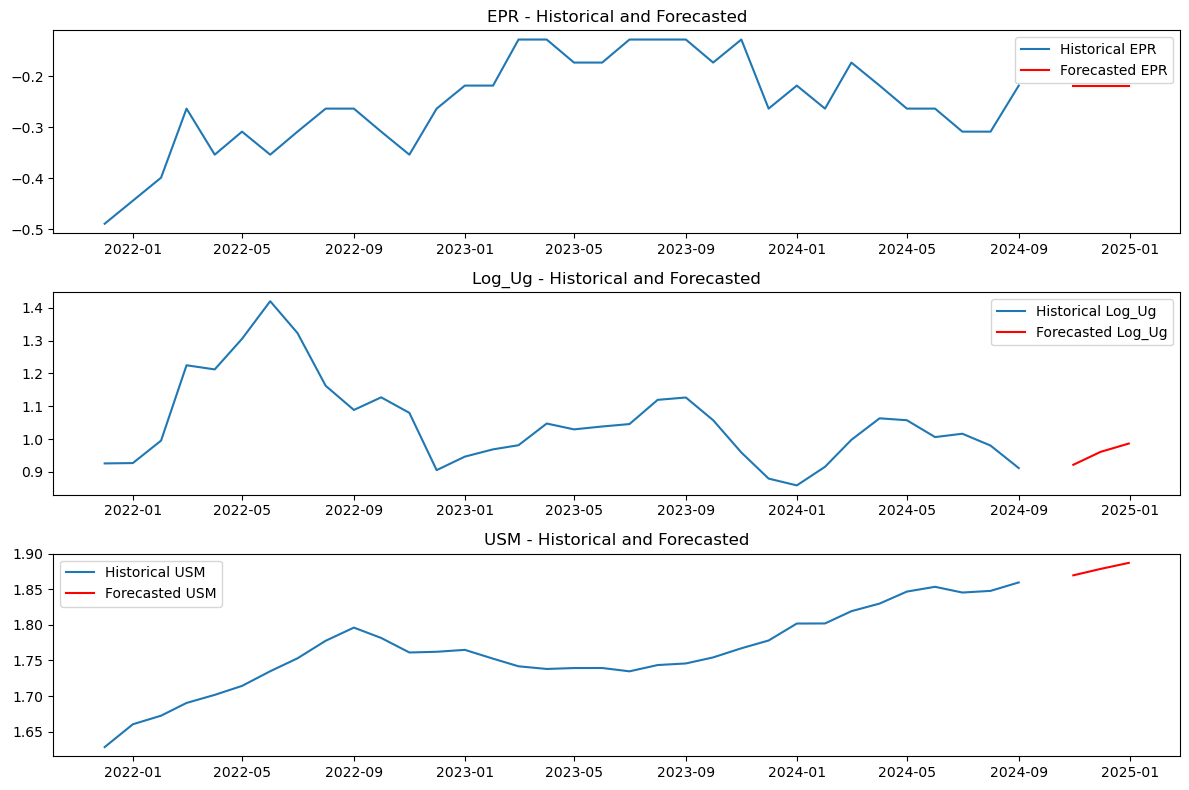

In [226]:
forecast_dates = pd.date_range(start='2024-10-01', periods=3, freq='M')

# Plot Historical EPR and Forecasted EPR
plt.figure(figsize=(12, 8)) 
plt.subplot(3, 1, 1) 
plt.plot(epr_data, label='Historical EPR')
plt.plot(forecast_dates, epr_forecast_values, label='Forecasted EPR', color='red')
plt.legend()
plt.title("EPR - Historical and Forecasted")

# Plot Historical Log_Ug and Forecasted Log_Ug
plt.subplot(3, 1, 2)
plt.plot(log_ug_data, label='Historical Log_Ug')
plt.plot(forecast_dates, log_ug_forecast_values, label='Forecasted Log_Ug', color='red')
plt.legend()
plt.title("Log_Ug - Historical and Forecasted")

# Plot Historical USM and Forecasted USM
plt.subplot(3, 1, 3)  
plt.plot(usm_data, label='Historical USM')
plt.plot(forecast_dates, usm_forecast_values, label='Forecasted USM', color='red')
plt.legend()
plt.title("USM - Historical and Forecasted")

plt.subplots_adjust(hspace=0.4)  
plt.tight_layout()
plt.show()

In [227]:
ug_lag1_last = 4.2

def predict_unemployment(epr, log_ug, usm, ug_lag1):
    temp_data = [[1, epr, log_ug, usm, ug_lag1]]
    predicted = gamma_model_covid.predict(temp_data)
    return predicted[0]

# Predict unemployment for 10/1/2024
epr_10 = epr_forecast_values[0]
log_ug_10 = log_ug_forecast_values[0]
usm_10 = usm_forecast_values[0]
unemployment_10 = predict_unemployment(epr_10, log_ug_10, usm_10, ug_lag1_last)

# Predict unemployment for 11/1/2024
epr_11 = epr_forecast_values[1]
log_ug_11 = log_ug_forecast_values[1]
usm_11 = usm_forecast_values[1]
unemployment_11 = predict_unemployment(epr_11, log_ug_11, usm_11, unemployment_10)

# Predict unemployment for 12/1/2024
epr_12 = epr_forecast_values[2]
log_ug_12 = log_ug_forecast_values[2]
usm_12 = usm_forecast_values[2]
unemployment_12 = predict_unemployment(epr_12, log_ug_12, usm_12, unemployment_11)

print(f"Predicted unemployment rates:")
print(f"10/1/2024: {unemployment_10}")
print(f"11/1/2024: {unemployment_11}")
print(f"12/1/2024: {unemployment_12}")

Predicted unemployment rates:
10/1/2024: 4.1786902317961125
11/1/2024: 4.169457855467229
12/1/2024: 4.170047938162892
